# Garbage Classification with EfficientNetV2B2

---
## Project Description
> In this project, we aim to develop a sophisticated **garbage classification system** leveraging the **EfficientNetV2B2** architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation.


**Goal:** To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and transfer learning for automated waste sorting.


---
## Challenges and Scope
**Key Challenge:** A notable challenge encountered is the inherent **class imbalance** within the dataset.

Transfer Learning is a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task. It also allows us to build accurate models in a time-saving way by starting from patterns learned when solving a different problem. This approach is beneficial when there is limited data for the new task, as the pre-trained model already has learned features that can be adapted. Transfer learning can significantly improve models' performance and efficiency in domains like computer vision and natural language processing.
    
### Benefits
-  **Reduces training time** — you don't start from scratch.
-  **Leverages learned features** from large datasets (like ImageNet).
-  **Improves performance**, especially with limited data.

---

##  How Does It Work?

1.  Load a pretrained model (e.g., ResNet, EfficientNet).
2.  **Freeze** the pretrained layers (optional).
3.  Add new layers for your custom task.
4.  Train on your new dataset (can also fine-tune).
## EfficientNetV2B2: Transfer Learning Backbone

EfficientNetV2B2 is a mid-sized model from the EfficientNetV2 family developed by **Google**, balancing performance and efficiency.

### ⚙️ Key Features:
- **Fused MBConv blocks** — enhance both training stability and speed.
- **Progressive learning** — enables better generalization with less computation.
- **Improved architecture** — achieves higher accuracy with optimized FLOPs.

---

## Why Use EfficientNetV2B2?

| Feature                  | Description                                       |
|--------------------------|---------------------------------------------------|
| Balanced Performance    | Great trade-off between speed and accuracy        |
| Scalable                 | Suitable for moderately complex datasets          |
| Pretrained on ImageNet   | Solid backbone for transfer learning tasks        |
| Efficient                | Faster convergence with fewer resources needed    |

---

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import zipfile
import shutil
import os

zip_path = 'Dataset.zip'
extract_path = '/content/Dataset'

if os.path.exists(extract_path):
    shutil.rmtree(extract_path)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

dataset_dir = "/content/Dataset/Dataset"


###  Core Libraries
- `tensorflow`: For deep learning model building and training.
- `numpy`: For numerical operations and array manipulation.
- `matplotlib.pyplot`: For plotting training curves and results.

In [6]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models

## 1.  Explore and Understand the Data
- Load image dataset using tools like `image_dataset_from_directory`.
- Visualize sample images from each class.
- Check the number of images per class to ensure balance.
- Understand image dimensions, color channels, and class labels.

### Load image dataset using tools like `image_dataset_from_directory`.
### Split data into training, validation, and testing sets.

`tf.keras.utils.image_dataset_from_directory(...)`  
Used to load images from a directory where each subfolder represents a class.

---

**path**  
Root directory path containing one subdirectory per class.

**shuffle=True**  
Randomly shuffles the image data. Useful during training to prevent the model from learning the order of the data.

**image_size=(128, 128)**  
Resizes all loaded images to this target size (width, height).  
This must match the input size expected by the model.

**batch_size=32**  
Number of images per batch during training.  
This affects memory usage and the frequency of model updates.

**validation_split=False**  
If set to a float (e.g., `0.2`), splits a portion of the data for validation.  
If `False`, no split is applied.

In [8]:
#Loading Dataset
dataset_dir= r"/content/Dataset/Dataset"

image_size = (224, 224)
batch_size = 32
seed = 42

# Load training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

# Get class names from validation dataset
val_class = val_ds.class_names

# Split validation into test and validation sets
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

# ✨ Pretty output section
print("\nDataset Summary")
print("-" * 30)

print("Class Names:")
for i, cls in enumerate(train_ds.class_names, 1):
    print(f"  {i}. {cls}")

print(f"\nTotal Classes     : {len(train_ds.class_names)}")
print(f"Training Batches  : {len(train_ds)}")
print(f"Validation Batches: {len(val_dat)}")
print(f"Test Batches      : {len(test_ds)}")
print("-" * 30)


Found 2527 files belonging to 6 classes.
Using 2022 files for training.
Found 2527 files belonging to 6 classes.
Using 505 files for validation.

Dataset Summary
------------------------------
Class Names:
  1. cardboard
  2. glass
  3. metal
  4. paper
  5. plastic
  6. trash

Total Classes     : 6
Training Batches  : 64
Validation Batches: 8
Test Batches      : 8
------------------------------


### Visualize sample images from each class.

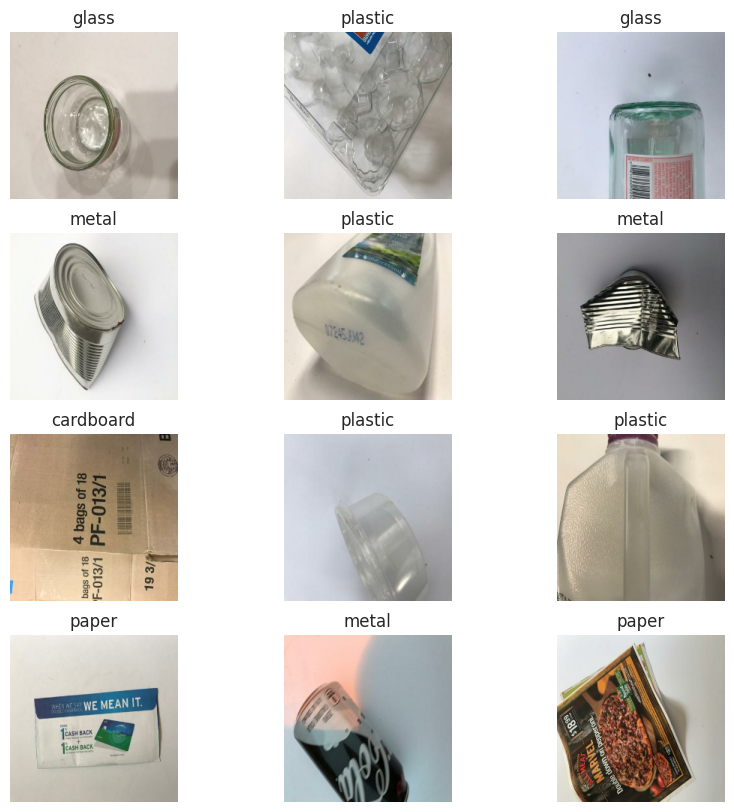

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

- ## Check the number of images per class to ensure balance
- ## Understand image properties like Image dimensions, Class labels


Class Distribution Summary:

    Class  Train (%)  Validation (%)  Test (%)  Overall (%)
cardboard      16.52           13.66     14.06        15.09
    glass      19.73           20.20     17.58        19.96
    metal      15.92           17.43     16.80        16.68
    paper      23.29           24.36     25.00        23.82
  plastic      19.44           17.62     19.14        18.53
    trash       5.09            6.73      7.42         5.91


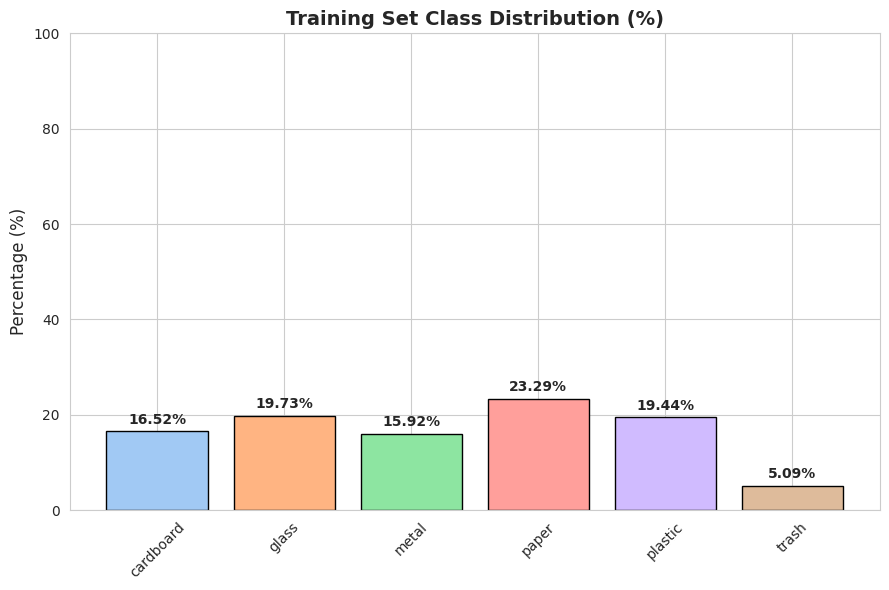

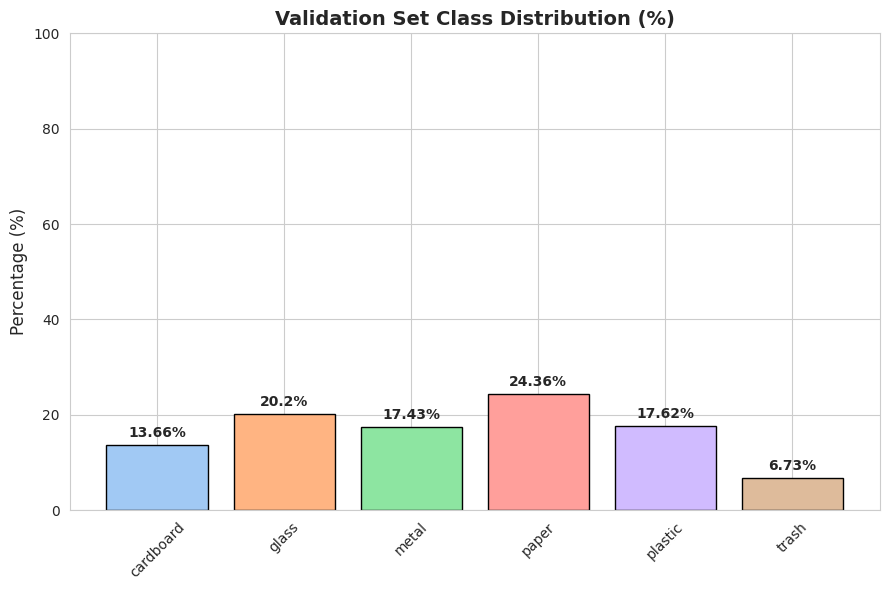

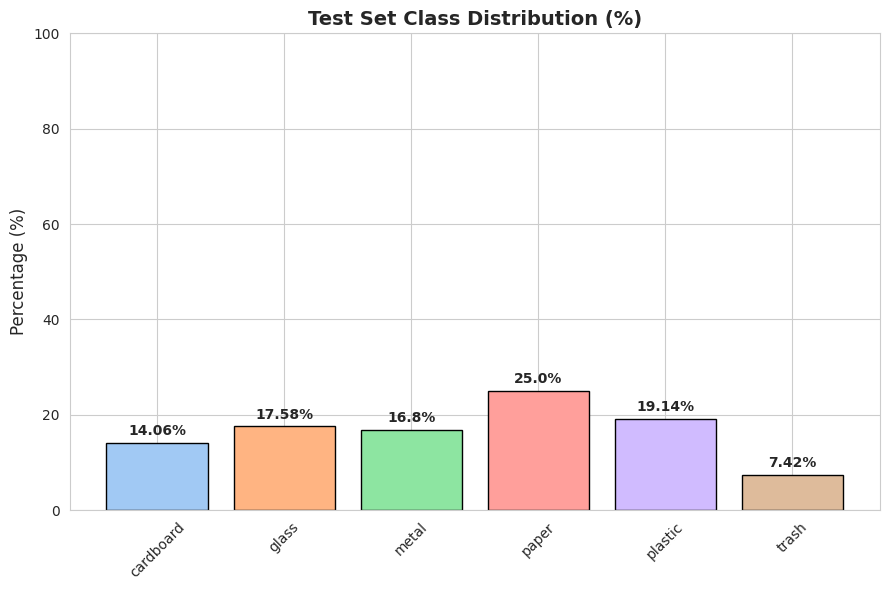

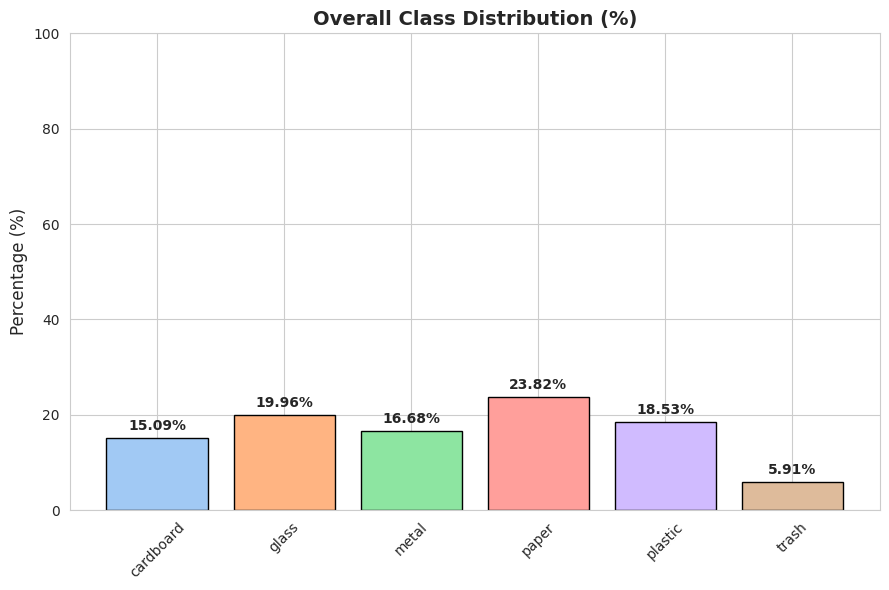

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Function to count class distribution (in %)
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            counts[class_names[label]] += 1
            total += 1

    return {k: round((v / total) * 100, 2) for k, v in counts.items()}

# Improved bar plot function with seaborn
def simple_bar_plot(dist, title):
    plt.figure(figsize=(9, 6))
    sns.set_style("whitegrid")

    bars = plt.bar(dist.keys(), dist.values(), color=sns.color_palette("pastel"), edgecolor='black')

    # Add value labels on top
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height}%',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

# Get class names
class_names = train_ds.class_names

# Compute distributions
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {k: round((train_dist[k] + val_dist[k]) / 2, 2) for k in class_names}

# Create DataFrame
dist_df = pd.DataFrame({
    'Class': class_names,
    'Train (%)': [train_dist[k] for k in class_names],
    'Validation (%)': [val_dist[k] for k in class_names],
    'Test (%)': [test_dist[k] for k in class_names],
    'Overall (%)': [overall_dist[k] for k in class_names],
})

# Print clean table
print("\nClass Distribution Summary:\n")
print(dist_df.to_string(index=False))

# Plot distributions
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")


#  Inference on Class Imbalance

The **"Garbage Image Dataset"** reveals a noticeable **imbalance** in the distribution of its image categories:

| Category     | Image Count | Updated Distribution |
|--------------|-------------|----------------|
| Cardboard | 403          | 15.09           |
|  Glass     | 501         | 19.96           |
|  Metal     | 410         | 16.68           |
|  Paper     | 594         | 23.82          |
|  Plastic   | 482         | 18.53         |
|  Trash     | 137         |  5.91          |

---

### Analogy:
> Imagine teaching a child to identify animals by showing them **95 pictures of cats** and just **5 pictures of dogs**.  
> They'd probably think **most pets are cats**, right?  
> Similarly, our model sees a lot of "**paper**" and very little "**trash**", which **biases** its understanding.

---

###  Key Problems Caused by Class Imbalance:

#### 1️ **Bias**
- The model may **overpredict common classes** like `"paper"` and **underpredict rare ones** like `"trash"`.

#### 2️ **Generalization Issues**
- If the real-world distribution is more balanced, the model may **fail to generalize** and **misclassify rare classes**.

#### 3️ **Accuracy Deception**
- The model might appear to have **high overall accuracy** just by **predicting the majority class**, while **failing** on underrepresented ones.

---

###  Solution Approaches :
- Use **class weights** to handle imbalanced data in training,
- Apply **data augmentation** to increase training data diversity
---

 **Conclusion**: Always check class distribution. A seemingly "accurate" model might just be **biased** toward the dominant class.

### 🛠️ Addressing Imbalance Using Class Weights:

To tackle our imbalanced image dataset, we'll utilize **class weights**. These weights assign more importance to underrepresented classes during training. The weights are computed inversely proportional to class frequencies using utilities like `compute_class_weight` from **scikit-learn**, based on the distribution of images in each class. The formula is:

$$
\text{weight(class)} = \frac{\text{total samples}}{\text{number of classes} \times \text{samples in that class}}
$$

These computed weights are then passed to the model.

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Count class occurrences and collect all labels
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (balanced)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Map class index to weight
class_weights = {i: round(w, 4) for i, w in enumerate(class_weights_array)}

# ✨ Display results nicely
print("\n📊 Class Distribution in Training Set")
print("-" * 40)
for i, name in enumerate(class_names):
    print(f"{i}. {name:<10} ➤ Samples: {class_counts[i]:<4} | Weight: {class_weights[i]}")
print("-" * 40)
print(f"\n🧮 Total Training Samples: {sum(class_counts.values())}")




📊 Class Distribution in Training Set
----------------------------------------
0. cardboard  ➤ Samples: 334  | Weight: 1.009
1. glass      ➤ Samples: 399  | Weight: 0.8446
2. metal      ➤ Samples: 322  | Weight: 1.0466
3. paper      ➤ Samples: 471  | Weight: 0.7155
4. plastic    ➤ Samples: 393  | Weight: 0.8575
5. trash      ➤ Samples: 103  | Weight: 3.2718
----------------------------------------

🧮 Total Training Samples: 2022


## 2.  Data Preprocessing / Preparation
- Resize and rescale images.
- Apply data augmentation (e.g., `RandomFlip`, `RandomRotation`, `RandomZoom`) to improve generalization.
- Normalize images (using `preprocess_input` if using pre-trained models like EfficientNet).

## 3.  Model Selection
- Choose a base model: Custom CNN or Transfer Learning (e.g., `EfficientNetV2B2`).
- Decide whether to use pre-trained weights (e.g., ImageNet).
- Define whether layers should be trainable or frozen during initial training.

## 4.  Model Training
- Build the model architecture using `Sequential` or Functional API.
- Compile the model with loss function ( `sparse_categorical_crossentropy`), optimizer (e.g., `Adam`), and evaluation metrics (`accuracy`).

## 5.  Model Tuning and Optimization
- Tune hyperparameters: learning rate, batch size, number of layers, dropout rate.
- Use callbacks: `EarlyStopping`,
- Optionally perform fine-tuning on pre-trained models by unfreezing some layers.


📦 Starting Model Training...
Epochs       : 15
Class Weights: {0: np.float64(1.009), 1: np.float64(0.8446), 2: np.float64(1.0466), 3: np.float64(0.7155), 4: np.float64(0.8575), 5: np.float64(3.2718)}
Checkpoint   : Best model saved to 'best_model224.keras'
Early Stop   : Enabled with patience=3



0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3449 - loss: 1.6589
Epoch 1: val_accuracy improved from -inf to 0.71287, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 613s 8s/step - accuracy: 0.3468 - loss: 1.6561 - val_accuracy: 0.7129 - val_loss: 1.0245
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7226 - loss: 0.9098
Epoch 2: val_accuracy improved from 0.71287 to 0.81188, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 531s 8s/step - accuracy: 0.7228 - loss: 0.9087 - val_accuracy: 0.8119 - val_loss: 0.5902
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8161 - loss: 0.5770
Epoch 3: val_accuracy improved from 0.81188 to 0.86931, saving model to best_model224.keras
64/64 ━━━━━━━━━━━━━━━━━━━━ 559s 8s/step - accuracy: 0.8164 - loss: 0.5760 - val_accuracy: 0.8693 - val_loss: 0.4164
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9115 - loss: 0.3301
Epoch 4: val_accuracy improved from 0.86931 to 

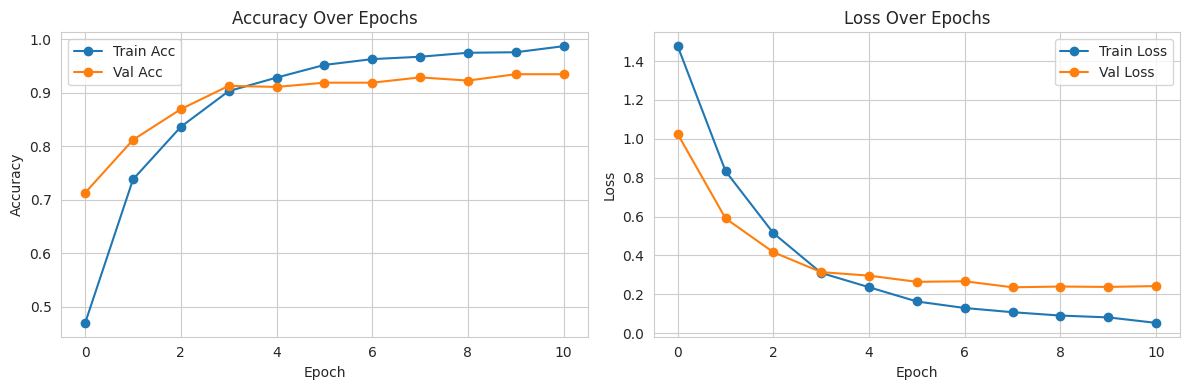

In [26]:
# Unified Model Training Pipeline with 128x128 Image Input and Enhanced Output

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, callbacks
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
import tensorflow as tf
import pickle

# Data Augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Load Pretrained EfficientNetV2B2 with matching input size
base_model = EfficientNetV2B2(
    include_top=False,
    input_shape=(224, 224, 3),
    include_preprocessing=True,
    weights='imagenet'
)

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Build Final Model
model = Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(6, activation='softmax')
])

# Compile Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

checkpoint = callbacks.ModelCheckpoint(
    filepath='best_model224.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Pre-training Summary
epochs = 15
print("\n📦 Starting Model Training...")
print(f"Epochs       : {epochs}")
print(f"Class Weights: {class_weights}")
print(f"Checkpoint   : Best model saved to 'best_model224.keras'")
print(f"Early Stop   : Enabled with patience=3\n")

# Train the Model with Tqdm progress bar
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weights,
    batch_size=32,
    callbacks=[early, checkpoint, TqdmCallback(verbose=1)]
)

# Display training log as a table
df_log = pd.DataFrame(history.history)
print("\n📊 Training Log Summary:")
print(df_log.to_string(index=True))

# Save history for later comparison
with open("history224.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Plot Accuracy and Loss Graphs
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [33]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model("best_model224.keras")
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 7, 7, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [34]:
# Find the base model layer by layer name or type
for layer in model.layers:
    if isinstance(layer, tf.keras.Model) and "efficientnetv2b2" in layer.name.lower():
        base_model = layer
        break

# Print summary of the extracted base model
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_6[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          0 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 112, 112,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 112, 112,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 112, 112,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 112, 112,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

### Model Architecture and Layer Utilities

- **Sequential**: A simple way to build models by stacking layers one after the other in a linear fashion.

- **RandomFlip**: A data augmentation layer that flips input images horizontally or vertically at random, helping the model generalize better.

- **RandomRotation**: Randomly rotates images by a specified angle range during training to make the model invariant to orientation.

- **RandomZoom**: Applies random zoom-in or zoom-out to training images, helping the model recognize objects at various scales.

- **Dropout**: A regularization method that randomly "drops" (sets to zero) a fraction of input units during training to prevent overfitting.

- **GlobalAveragePooling2D**: Reduces each feature map to a single number by taking the average, reducing model parameters and helping prevent overfitting.

- **Dense**: A fully connected neural network layer used to learn complex features and typically found at the end of the model for classification.

- **Input**: Specifies the input shape and data type for the model; acts as the starting point of the model architecture.

- **EfficientNetV2B2**: A pre-trained convolutional neural network from the EfficientNetV2 family, known for being lightweight and high-performing, commonly used for transfer learning.

### 🔁 Callbacks
- `EarlyStopping`: To stop training when validation performance stops improving

### Train the model using `.fit()` with appropriate `epochs`, `batch_size`, and callbacks like `EarlyStopping`.

# Model Performance Visualization: Accuracy & Loss Trends

## 5.  Model Evaluation
- Plot training and validation accuracy/loss curves.
- Evaluate model performance on validation or test set.
- Use metrics like:
  - **Confusion Matrix**
  - **Classification Report** (Precision, Recall, F1-score)
  - `confusion_matrix`, `classification_report`: To evaluate the model's classification performance.


Loading Model: best_model224.keras

Evaluating Model on Test Dataset...
--------------------------------------------------
✅ Test Accuracy : 0.9258
📉 Test Loss     : 0.2594
--------------------------------------------------

📊 Classification Report:
--------------------------------------------------
              precision    recall  f1-score   support

   cardboard       0.92      0.95      0.93        37
       glass       0.96      0.91      0.93        47
       metal       0.90      0.98      0.94        48
       paper       0.96      0.96      0.96        57
     plastic       0.97      0.83      0.89        46
       trash       0.76      0.90      0.83        21

    accuracy                           0.93       256
   macro avg       0.91      0.92      0.92       256
weighted avg       0.93      0.93      0.93       256

--------------------------------------------------


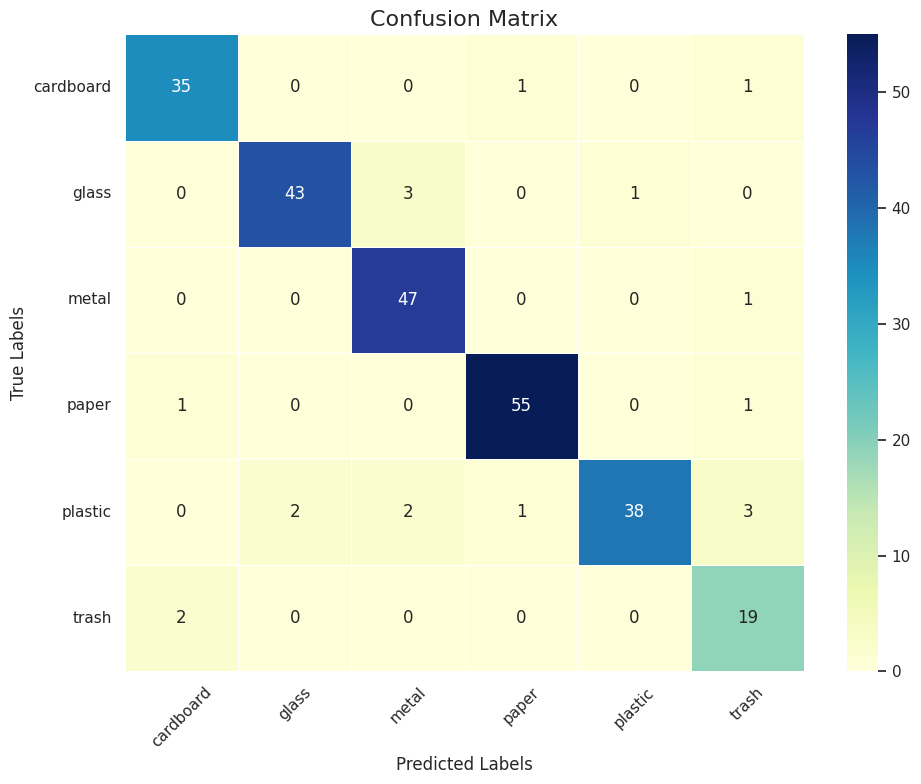

In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

def evaluate_model(model_path, test_dataset, class_names):
    # Load the model
    print(f"\nLoading Model: {model_path}")
    model = tf.keras.models.load_model(model_path)

    # Evaluate on test set
    print("\nEvaluating Model on Test Dataset...\n" + "-"*50)
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"✅ Test Accuracy : {accuracy:.4f}")
    print(f"📉 Test Loss     : {loss:.4f}")
    print("-"*50)

    # True and predicted labels
    y_true = np.concatenate([labels.numpy() for _, labels in test_dataset])
    y_pred_probs = model.predict(test_dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Classification Report
    print("\n📊 Classification Report:\n" + "-"*50)
    report = classification_report(y_true, y_pred, target_names=class_names)
    print(report)
    print("-"*50)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5,
                xticklabels=class_names, yticklabels=class_names)

    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Labels", fontsize=12)
    plt.ylabel("True Labels", fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# 🧪 Example usage
evaluate_model("best_model224.keras", test_ds_eval, class_names)


## 7.  Final Testing and Save the Model
- Evaluate the final model on the unseen **test dataset**.

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


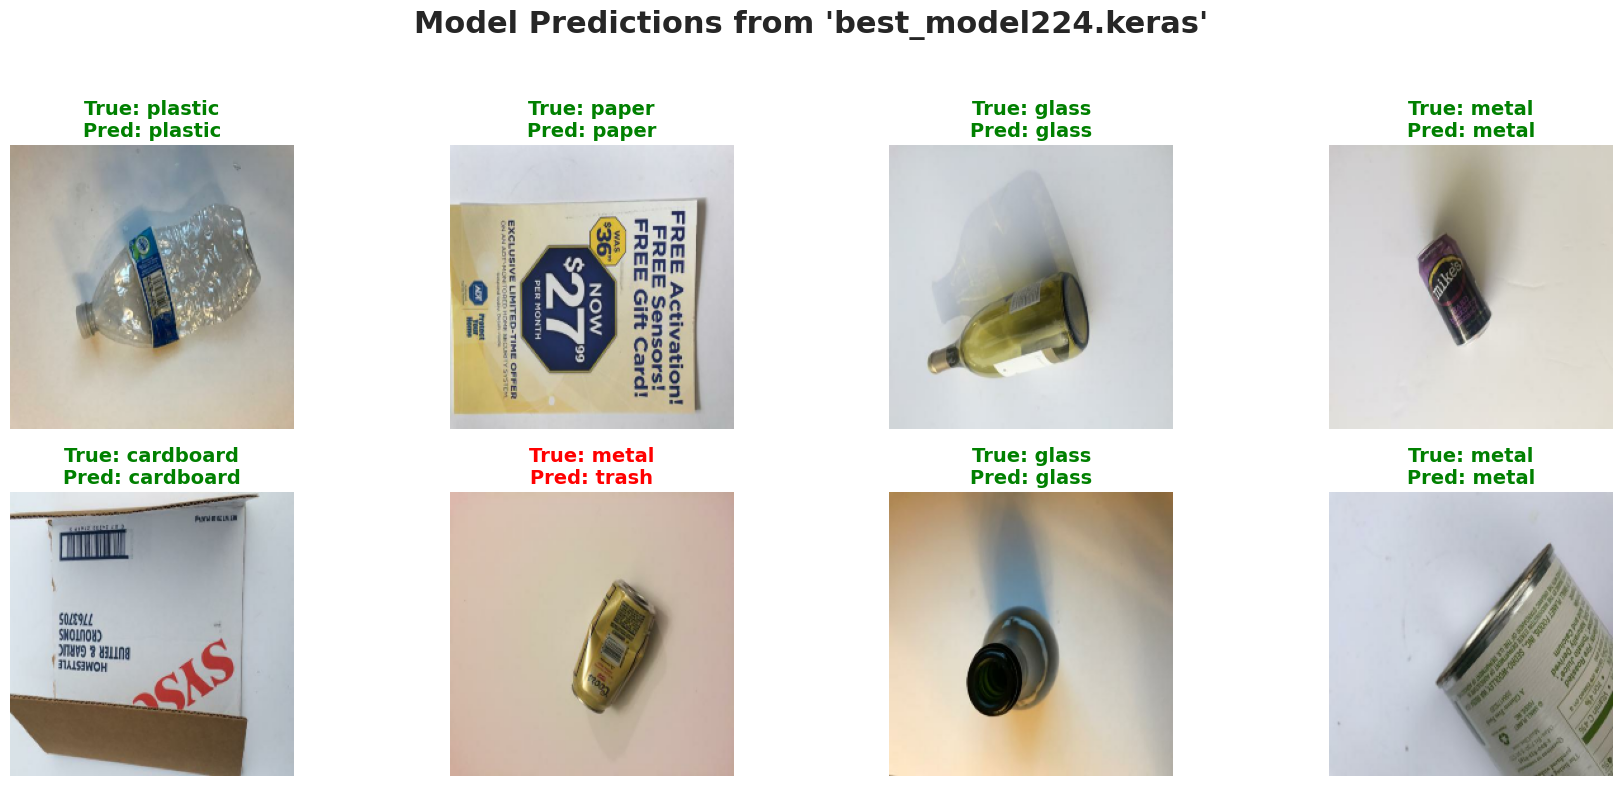

In [20]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Load your trained model
model_path = 'best_model224.keras'  # Change if needed
model = tf.keras.models.load_model(model_path)

# Get class names from training dataset
class_names = train_ds.class_names

# Shuffle test dataset before sampling
test_ds_eval_shuffled = test_ds_eval.shuffle(1000, reshuffle_each_iteration=True)

# Take one random batch from test dataset and predict
for images, labels in test_ds_eval_shuffled.take(1):
    predictions = model.predict(images)
    pred_labels = tf.argmax(predictions, axis=1)

    # Plot first 8 images with predictions
    plt.figure(figsize=(18, 8))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_cls = class_names[labels[i]]
        pred_cls = class_names[pred_labels[i]]

        # Green if correct, red if wrong
        title_color = 'green' if true_cls == pred_cls else 'red'
        plt.title(f"True: {true_cls}\nPred: {pred_cls}", color=title_color, fontsize=14, fontweight='bold')  # ← increased font size here
        plt.axis("off")

    plt.suptitle(f"Model Predictions from '{model_path}'", fontsize=22, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


**Save the trained model using `model.save()` or `save_model()` for future inference.**

In [21]:
# Save model in Keras format with architecture, weights, and training configuration
model.save('Effiicientnetv2b2.keras')

# Load your Keras model
model = tf.keras.models.load_model('Effiicientnetv2b2.keras')

## 8.  Model Deployment (Optional)
- Create a web interface using **Gradio**.
- Load the saved model and preprocess input images before prediction.

In [22]:
!pip install gradio

### 🌐 Gradio Interface and Preprocessing
- `gr`: To build a web interface for the model.
- `PIL.Image`: For handling image input in Gradio.
- `preprocess_input`: Preprocessing method for EfficientNet.
- `load_model`: For loading a saved model for inference.

In [30]:
import tensorflow as tf
import numpy as np
import gradio as gr
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

# Load the trained model
model = load_model("best_model224.keras")

# Class labels
class_names = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']

# Classify image
def classify_image(img):
    if img is None:
        return "Please upload or capture an image."

    try:
        img = img.resize((224, 224))
        img_array = np.array(img, dtype=np.float32)

        if img_array.shape != (224,224,224):
            return f"Error: Unexpected shape {img_array.shape}."

        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)
        prediction = model.predict(img_array, verbose=0)[0]

        predicted_class_index = np.argmax(prediction)
        predicted_class_name = class_names[predicted_class_index]
        confidence = float(prediction[predicted_class_index])

        return f"Prediction: {predicted_class_name} (Confidence: {confidence:.2%})"

    except Exception as e:
        return f"Error: {str(e)}"

# Clear input
def clear_input():
    return None

# Gradio interface
with gr.Blocks() as iface:
    gr.Markdown("# Waste Classifier")
    gr.Markdown("Upload or capture an image to classify waste.")
    image_input = gr.Image(type="pil", sources=["upload", "webcam"], label="Image")
    output = gr.Textbox(label="Result")
    clear_button = gr.Button("Clear")

    image_input.change(fn=classify_image, inputs=image_input, outputs=output)
    clear_button.click(fn=clear_input, inputs=None, outputs=image_input)

iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://83863228a62b5c12c8.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


## Conclusion

The image classification model demonstrates strong accuracy in identifying objects, leveraging deep learning to refine predictions effectively. Its robust performance ensures reliable classification, making it a valuable tool for various applications.